Alunos:

*   Andréa Fonseca
*   Fábio Cardoso
*   Eduardo Leite



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
!mkdir data

In [ ]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2035k      0  0:00:05  0:00:05 --:--:-- 3577k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224), # augmentation
    transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [ ]:
for param in model.parameters():
  print(param.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada - Remover a cabeça de classificação para substituir por aquilo que é necessário ao problema
# A ultima camada poderia não precisar ser substituída caso quisessemos diagnosticar imagens já conhecidas, em que a camada já foi treinada.
# Nesse caso, somente reduziriamos a qtde de saídas para duas (exemplo: queremos reconhecer notebook e meat-loaf, que já são "conhecidos" dessa camada).
# Como queremos o reconhecimento de imagens ovas, no caso tatu e calango, precisamos mesmo substituir a camada, que deverá ser retreinada para essas categorias.
# As camadas anteriores já podem reconhecer partes das imagens, como pata, olho ou rabo, diagnóstico que nos será útil, sem necessidade de retreinamento.
# Daí, essas camadas serem congeladas.
model.fc = nn.Linear(model.fc.in_features, 2) # quando inclui essa nova camada, ela ja vem "descongelada" e não precisa do RequiresGrad = True
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN
# Ainda que a rede inteira passe pelo treinamento, somente os pesos da última camada sao atualizados
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch 1, Train Loss: 0.697, Train Accuracy: 56.50%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.444, Val Accuracy: 86.07%


100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch 2, Train Loss: 0.436, Train Accuracy: 84.75%
Epoch 2, Val Loss: 0.240, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Epoch 3, Train Loss: 0.318, Train Accuracy: 87.50%
Epoch 3, Val Loss: 0.177, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Epoch 4, Train Loss: 0.306, Train Accuracy: 87.50%
Epoch 4, Val Loss: 0.163, Val Accuracy: 98.36%


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Epoch 5, Train Loss: 0.247, Train Accuracy: 90.50%
Epoch 5, Val Loss: 0.135, Val Accuracy: 98.36%
Treinamento concluído


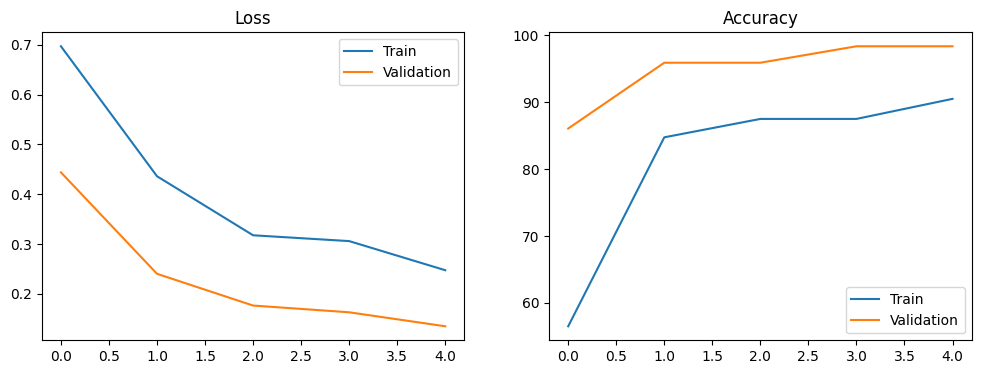

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 98.36%


In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

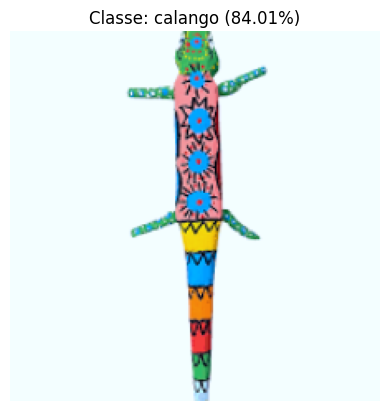

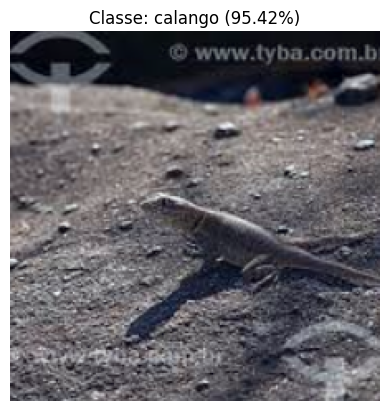

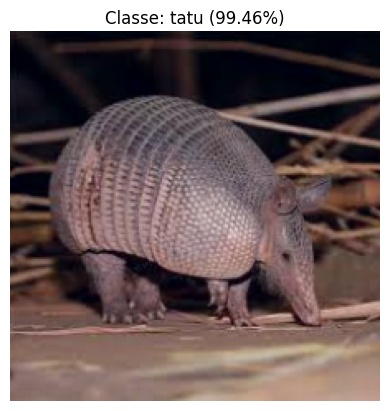

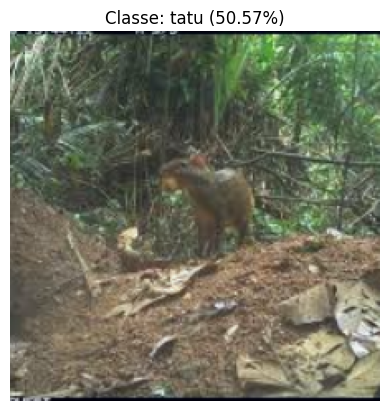

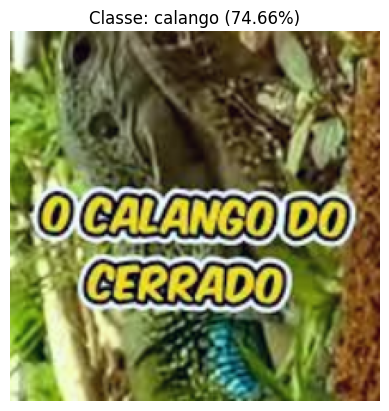

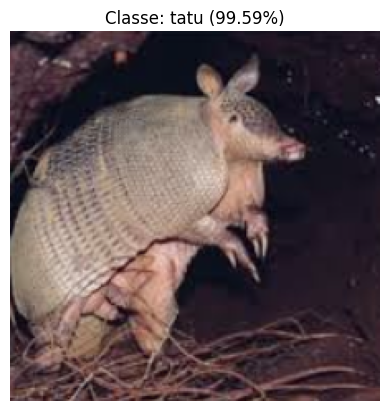

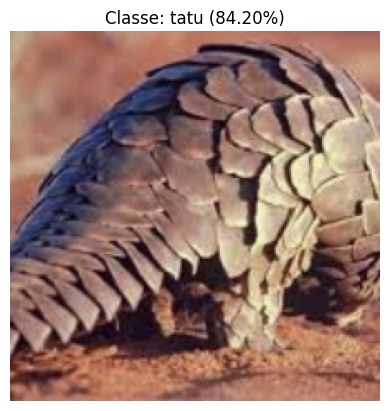

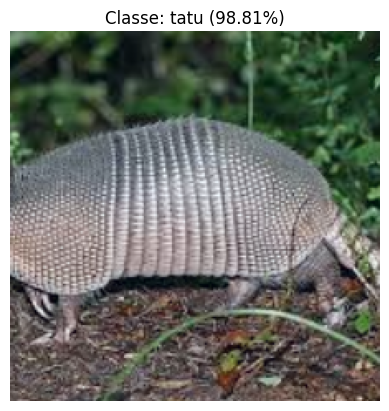

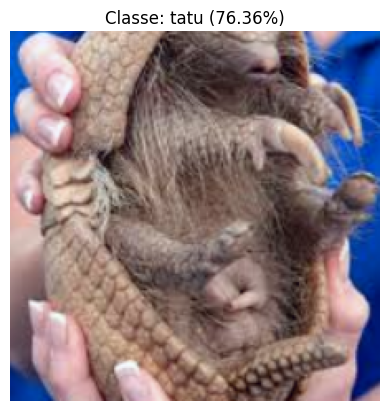

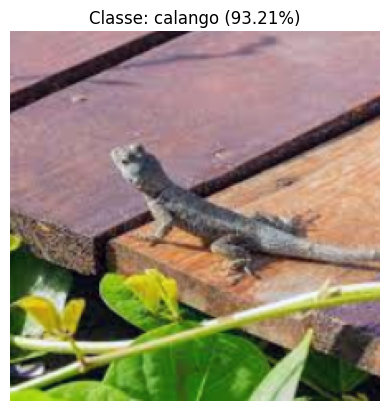

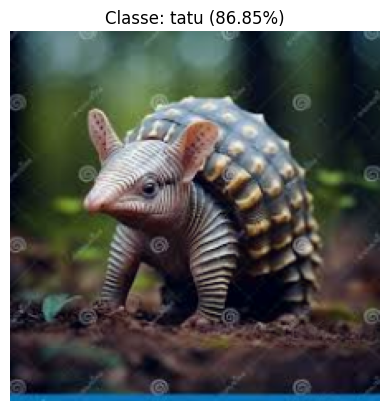

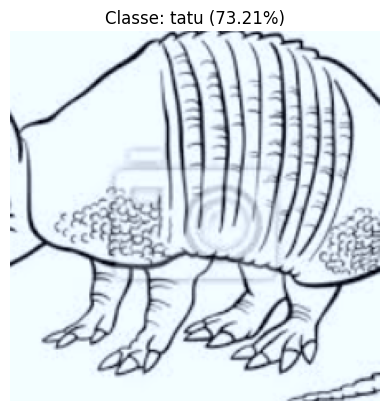

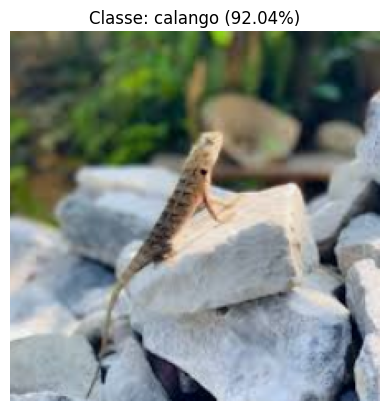

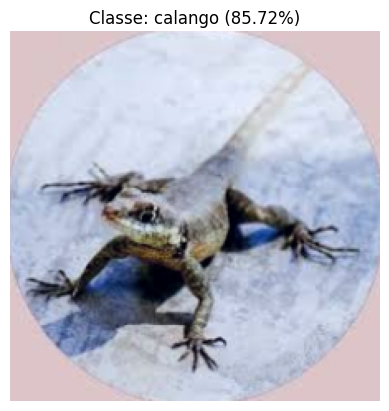

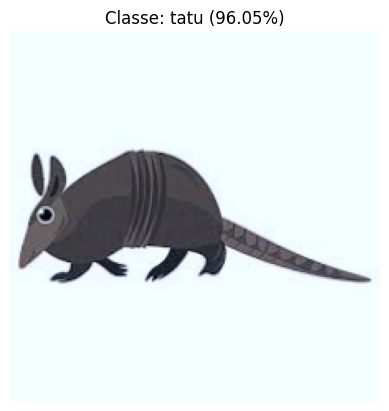

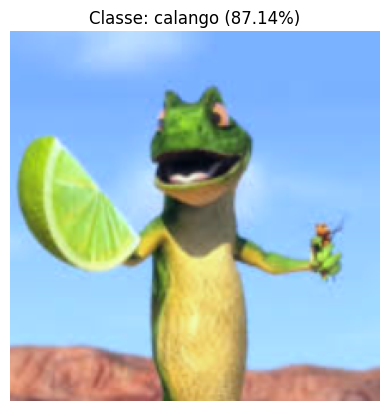

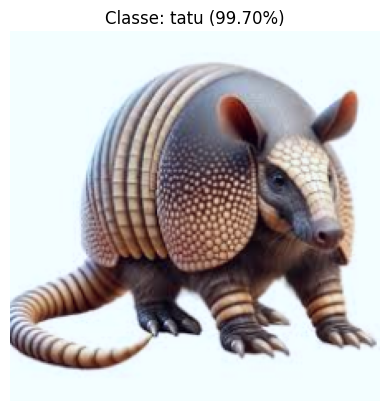

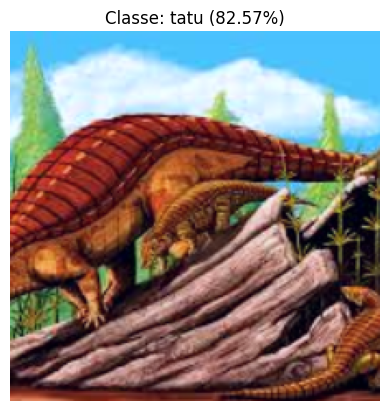

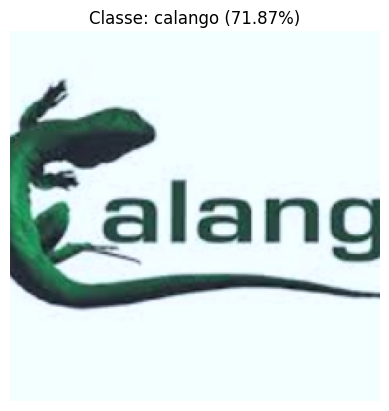

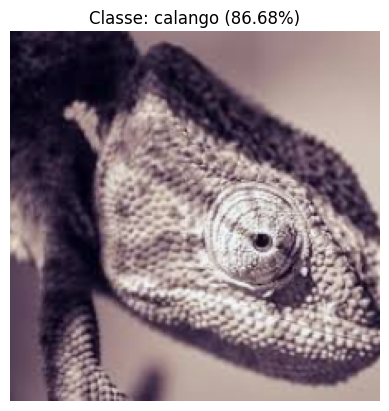

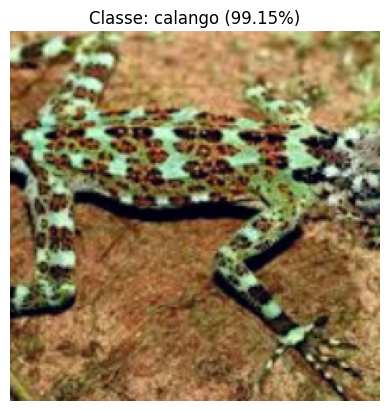

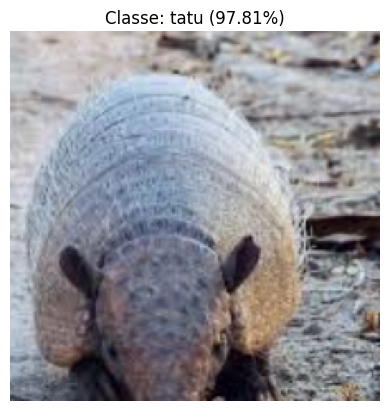

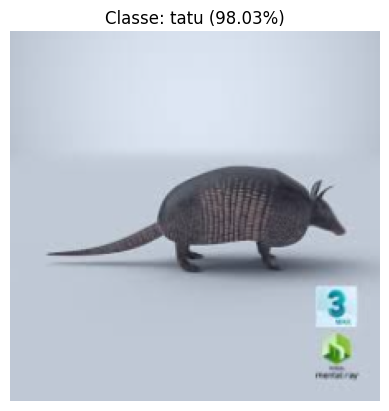

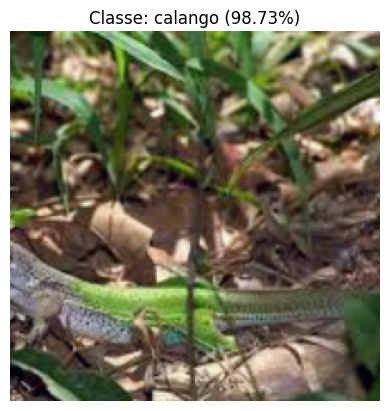

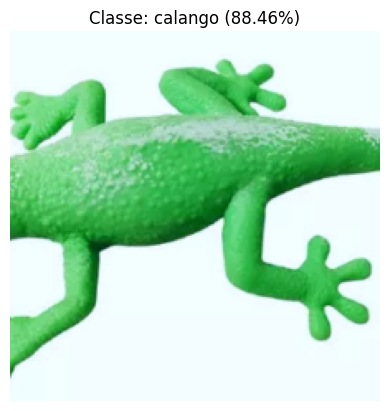

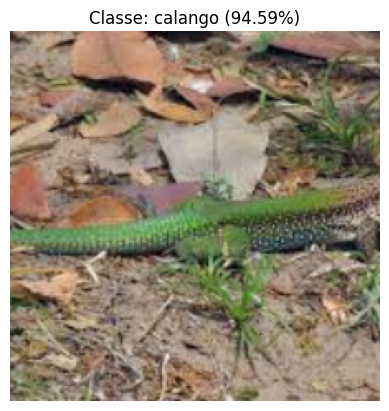

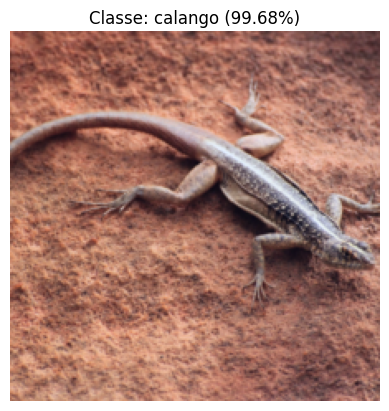

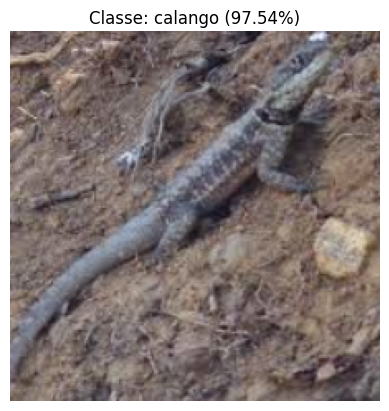

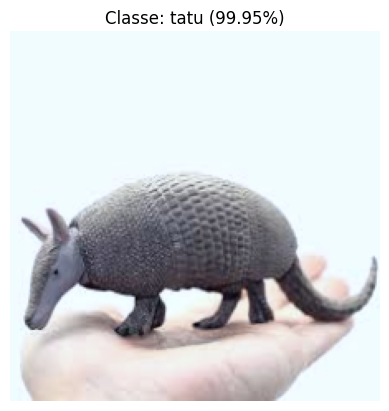

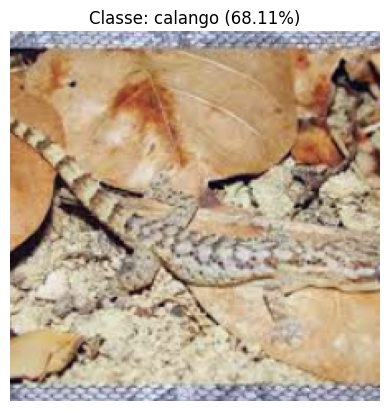

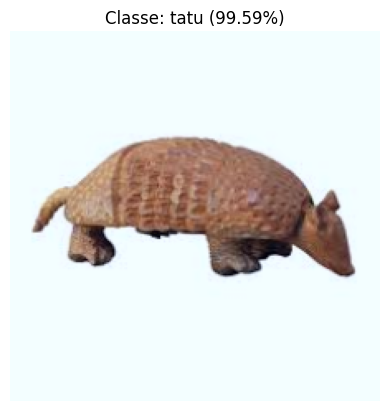

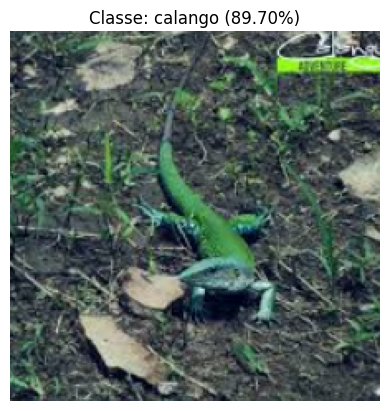

In [ ]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

Os valores proximos de 50% indicam confusão no diagnóstico.
Para evitar alucinação, convém haver uma categoria do tipo "não sei" ou criar um threshold (por exemplo 90%) abaixo do qual o diagnóstico é "não sei".

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [ ]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug) # sem data augmentation
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Linear(model.fc.in_features, 2) # quando inclui essa nova camada, ela ja vem "descongelada" e não precisa do RequiresGrad = True
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Epoch 1, Train Loss: 0.595, Train Accuracy: 67.00%
Epoch 1, Val Loss: 0.383, Val Accuracy: 89.34%


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


Epoch 2, Train Loss: 0.386, Train Accuracy: 82.75%
Epoch 2, Val Loss: 0.275, Val Accuracy: 90.98%


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Epoch 3, Train Loss: 0.258, Train Accuracy: 91.50%
Epoch 3, Val Loss: 0.222, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


Epoch 4, Train Loss: 0.254, Train Accuracy: 90.25%
Epoch 4, Val Loss: 0.170, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Epoch 5, Train Loss: 0.189, Train Accuracy: 93.75%
Epoch 5, Val Loss: 0.150, Val Accuracy: 95.08%
Treinamento concluído


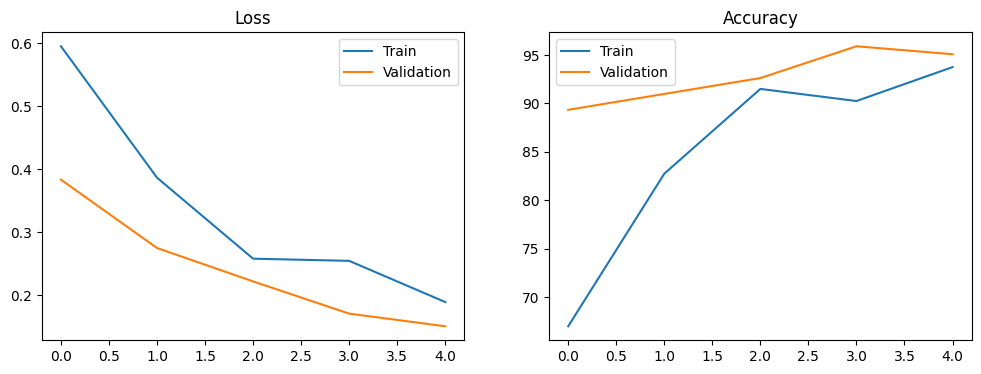

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.08%


Refazendo os dataloaders a partir do dataset sem augmentation e refazendo o modelo, com a substituição e retreinamento somente da útima camada com esse novo dataloader, sem augmentation, as curvas de perda e acurácia parecem convergir mais rapidamente, considerando o mesmo número de épocas de treinamento do modelo, ainda que a acurácia tenha sido menor.

A convergência mais cedo foi devida ao menor número de imagens no dataset, refletindo uma complexidade menor. A convergência mais cedo não significa necessariamente melhor desempenho em diagnóstico do modelo.

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Descongelando a layer4
for param in model.layer4[1].parameters():
  param.requires_grad = True

for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias


In [ ]:
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug) # sem data augmentation
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  7.58it/s]


Epoch 1, Train Loss: 0.550, Train Accuracy: 73.75%
Epoch 1, Val Loss: 0.324, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  8.47it/s]


Epoch 2, Train Loss: 0.358, Train Accuracy: 85.50%
Epoch 2, Val Loss: 0.203, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch 3, Train Loss: 0.271, Train Accuracy: 88.75%
Epoch 3, Val Loss: 0.152, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:01<00:00,  8.43it/s]


Epoch 4, Train Loss: 0.253, Train Accuracy: 90.00%
Epoch 4, Val Loss: 0.123, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


Epoch 5, Train Loss: 0.183, Train Accuracy: 94.50%
Epoch 5, Val Loss: 0.110, Val Accuracy: 97.54%
Treinamento concluído


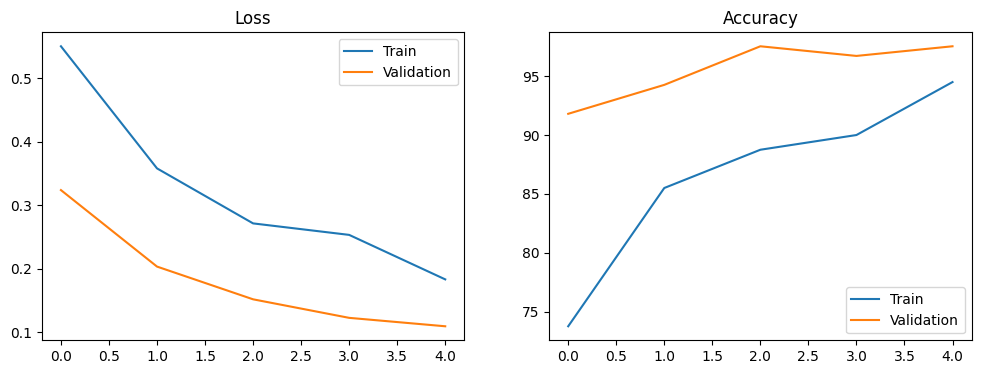

In [ ]:
plot_history(history)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [ ]:
model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 138MB/s]


In [ ]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  9.92it/s]


Epoch 1, Train Loss: 0.665, Train Accuracy: 61.00%
Epoch 1, Val Loss: 0.474, Val Accuracy: 89.34%


100%|██████████| 13/13 [00:01<00:00, 11.08it/s]


Epoch 2, Train Loss: 0.505, Train Accuracy: 79.00%
Epoch 2, Val Loss: 0.299, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:01<00:00, 11.25it/s]


Epoch 3, Train Loss: 0.408, Train Accuracy: 85.25%
Epoch 3, Val Loss: 0.220, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Epoch 4, Train Loss: 0.352, Train Accuracy: 87.50%
Epoch 4, Val Loss: 0.185, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:01<00:00, 11.14it/s]


Epoch 5, Train Loss: 0.336, Train Accuracy: 87.00%
Epoch 5, Val Loss: 0.161, Val Accuracy: 97.54%
Treinamento concluído


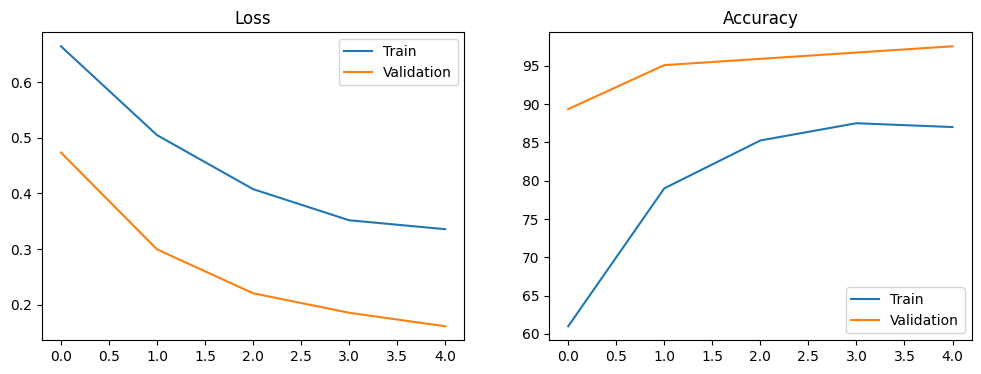

In [ ]:
plot_history(history)